# Hyperoptimization

## Import section

In [16]:
import sys
import os
from functools import partial

import pandas as pd
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch

sys.path.append("../../")

from ptgnn.runtime_config.config_helpers import run_config_adapter, load_and_merge_default_configs
from ptgnn.runtime_config.config import import_as, export_as

In [17]:
from ray import tune, train
import os

## Load default config

In [3]:
# fetching config file
benchmark_config = import_as("configs/hyper_param_opt/benchmark_instructions_rs_chienn.yaml")
display(benchmark_config)

{'output_dir': 'results/rs_chienn',
 'config_files': ['configs/datasets/rs_dataset.yaml',
  'configs/models/chienn.yaml',
  'configs/general.yaml',
  'configs/hyper_param_opt/subsetting.yaml'],
 'num_samples': 2}

In [4]:
default_config = load_and_merge_default_configs(
    benchmark_config['config_files']
)
display(default_config)

{'data': {'dataset': {'type': 'rs', 'mask_chiral_tasks': True},
  'loader': {'general': {'n_neighbors_in_circle': 3,
    'batch_size': 32,
    'num_workers': 0},
   'train': {'sampler': 'single_conformer_sampler'},
   'val': {'sampler': 'full_batch'},
   'test': {'sampler': 'full_batch'}},
  'subset_size': 10000},
 'training': {'loss_function': 'cross_entropy',
  'optimization_metric': 'accuracy',
  'optimization_metric_mode': 'max',
  'task_type': 'classification',
  'n_max_epochs': 100,
  'clip_grad_norm': True},
 'model': {'out_dim': 1,
  'mode': 'custom',
  'hidden_dim': 128,
  'modules': {0: {'type': 'graph_embedding',
    'parameter': {'node_type': 'linear', 'edge_type': 'linear'}},
   1: {'type': 'gps_layer',
    'parameter': {'local_model': 'chienn', 'local_model_params': {}},
    'times': 5}},
  'head': {'type': 'san_head', 'n_layer': 3, 'pool_function': 'add'}},
 'optimizer': {'type': 'adam_w',
  'base_learning_rate': 0.001,
  'weight_decay': 1e-05},
 'scheduler': {'type': 'c

In [5]:
# create absolute path to root dict that is not hyper-opt-run specific
default_config['data']['dataset']['root'] = os.path.abspath(
    os.path.join("src", default_config['data']['dataset']['type'])
)

In [6]:
# currently limit number of epochs
default_config['training']['n_max_epochs'] = 3

In [7]:
display(default_config)

{'data': {'dataset': {'type': 'rs',
   'mask_chiral_tasks': True,
   'root': 'D:\\DATEN\\Masterarbeit_PTGNN\\notebooks\\hyperoptimization\\src\\rs'},
  'loader': {'general': {'n_neighbors_in_circle': 3,
    'batch_size': 32,
    'num_workers': 0},
   'train': {'sampler': 'single_conformer_sampler'},
   'val': {'sampler': 'full_batch'},
   'test': {'sampler': 'full_batch'}},
  'subset_size': 10000},
 'training': {'loss_function': 'cross_entropy',
  'optimization_metric': 'accuracy',
  'optimization_metric_mode': 'max',
  'task_type': 'classification',
  'n_max_epochs': 3,
  'clip_grad_norm': True},
 'model': {'out_dim': 1,
  'mode': 'custom',
  'hidden_dim': 128,
  'modules': {0: {'type': 'graph_embedding',
    'parameter': {'node_type': 'linear', 'edge_type': 'linear'}},
   1: {'type': 'gps_layer',
    'parameter': {'local_model': 'chienn', 'local_model_params': {}},
    'times': 5}},
  'head': {'type': 'san_head', 'n_layer': 3, 'pool_function': 'add'}},
 'optimizer': {'type': 'adam_w'

## Define search space

In [8]:
# define search space
search_space = {
    'model': {
        'modules': {
            1: {
                'times': tune.randint(1, 7)
            }
        }
    }
}

In [ ]:
# todo: search space also defined in config yaml? with eval maybe?

## Define trainable function

In [9]:
#trainable_function = partial(
#    run_config_adapter,
#    default_config=default_config,
#    report=True,
#    verbose=False
#)

In [10]:
def trainable_function(config):
    run_config_adapter(
        config,
        default_config=default_config,
        report=True,
        verbose=False,
        device=None
    )

## Short test

In [12]:
test_config = {
    'training': {
        'n_max_epochs': 2
    }
}

In [13]:
test_fn = partial(
    run_config_adapter,
    default_config=default_config,
    report=False,
    verbose=True,
    device='cuda'
)
test_fn(test_config)

312it [01:04,  4.81it/s]
100%|██████████| 313/313 [00:12<00:00, 25.28it/s]
312it [01:04,  4.86it/s]
100%|██████████| 313/313 [00:11<00:00, 26.96it/s]


,train_accuracy,train_precision,train_recall,train_f1,train_auc,train_mean_loss,train_sum_loss,val_accuracy,val_precision,val_recall,val_f1,val_auc,val_mean_loss,val_sum_loss
0,0.51,0.67,0.05,0.10,0.55,0.981054,306.088994,0.51,0.67,0.05,0.09,0.55,0.976364,305.601805
1,0.99,1.00,0.99,0.99,1.00,0.017813,5.557787,1.00,1.00,1.00,1.00,1.00,0.000069,0.021684


In [31]:
test_fn = partial(
    run_config_adapter,
    default_config=default_config,
    report=False,
    verbose=True,
    device='cpu'
)
test_fn(test_config)

312it [02:49,  1.84it/s]
100%|██████████| 313/313 [00:32<00:00,  9.75it/s]
312it [02:22,  2.20it/s]
100%|██████████| 313/313 [00:28<00:00, 11.15it/s]


,train_accuracy,train_precision,train_recall,train_f1,train_auc,train_mean_loss,train_sum_loss,val_accuracy,val_precision,val_recall,val_f1,val_auc,val_mean_loss,val_sum_loss
0,0.51,0.67,0.05,0.10,0.55,0.981054,306.089000,0.51,0.67,0.05,0.09,0.55,0.976364,305.601873
1,0.99,1.00,0.99,0.99,1.00,0.017814,5.557829,1.00,1.00,1.00,1.00,1.00,0.000069,0.021534


## Set up tuner

In [11]:
# fetch score to optimize
optimization_score = "val_" + default_config['training']['optimization_metric']
score_mode = default_config['training']['optimization_metric_mode']

In [12]:
# define tuner and execute
tuner = tune.Tuner(
    tune.with_resources(trainable_function, {"cpu": 5, "gpu": 0.5}),
    #trainable=trainable_function,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric=optimization_score,
        mode=score_mode,
        search_alg=HyperOptSearch(
            metric=optimization_score,
            mode=score_mode,
            random_state_seed=420
        ),
        scheduler=ASHAScheduler(
            max_t=100,
            grace_period=1,
            reduction_factor=3,
            brackets=1
        ),
        num_samples=benchmark_config['num_samples'],
        max_concurrent_trials=2,
    ),
    run_config=train.RunConfig(
        progress_reporter=CLIReporter(
            metric_columns=optimization_score,
        )
    )
)
results = tuner.fit()

2024-03-26 20:46:49,198	INFO worker.py:1724 -- Started a local Ray instance.
2024-03-26 20:46:50,341	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-03-26 20:46:50,343	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-03-26 20:46:50 (running for 00:00:00.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 81.000: None | Iter 27.000: None | Iter 9.000: None | Iter 3.000: None | Iter 1.000: None
Logical resource usage: 5.0/20 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/johan/ray_results/trainable_function_2024-03-26_20-46-47
Number of trials: 1/2 (1 PENDING)
+-----------------------------+----------+-------+------------------------+
| Trial name                  | status   | loc   | model/modules/1/time   |
|                             |          |       | s                      |
|-----------------------------+----------+-------+------------------------|
| trainable_function_aefad43d | PENDING  |       |                        |
+-----------------------------+----------+-------+------------------------+


== Status ==
Current time: 2024-03-26 20:46:55 (running for 00:00:05.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 81.000: None |

2024-03-26 20:52:12,531	INFO tune.py:1042 -- Total run time: 322.19 seconds (322.16 seconds for the tuning loop).


== Status ==
Current time: 2024-03-26 20:52:12 (running for 00:05:22.17)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 81.000: None | Iter 27.000: None | Iter 9.000: None | Iter 3.000: 0.9966666666666667 | Iter 1.000: 0.5033333333333333
Logical resource usage: 5.0/20 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: aefad43d with val_accuracy=1.0 and parameters={'model': {'modules': {1: {'times': 2}}}}
Result logdir: C:/Users/johan/ray_results/trainable_function_2024-03-26_20-46-47
Number of trials: 2/2 (2 TERMINATED)
+-----------------------------+------------+-----------------+------------------------+
| Trial name                  | status     | loc             | model/modules/1/time   |
|                             |            |                 | s                      |
|-----------------------------+------------+-----------------+------------------------|
| trainable_function_aefad43d | TERMINATED | 127.0.0.1:8348  |                        |
| trainable_func

In [13]:
results

ResultGrid<[
  Result(
    metrics={'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'train_auc': 1.0, 'train_mean_loss': 5.0285492401750766e-05, 'train_sum_loss': 0.01568907362934624, 'val_accuracy': 1.0, 'val_precision': 1.0, 'val_recall': 1.0, 'val_f1': 1.0, 'val_auc': 1.0, 'val_mean_loss': 2.8138972612823316e-05, 'val_sum_loss': 0.008807498427813698},
    path='C:/Users/johan/ray_results/trainable_function_2024-03-26_20-46-47/trainable_function_aefad43d_1_times=2_2024-03-26_20-46-50',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'train_accuracy': 1.0, 'train_precision': 1.0, 'train_recall': 1.0, 'train_f1': 1.0, 'train_auc': 1.0, 'train_mean_loss': 0.0018663920307161036, 'train_sum_loss': 0.5823143135834243, 'val_accuracy': 0.99, 'val_precision': 0.99, 'val_recall': 1.0, 'val_f1': 0.99, 'val_auc': 1.0, 'val_mean_loss': 0.03447762322449466, 'val_sum_loss': 10.791496069266827},
    path='C:/Users/johan/ray_results/trainab

In [14]:
results.get_dataframe()

,train_accuracy,train_precision,train_recall,train_f1,train_auc,train_mean_loss,train_sum_loss,val_accuracy,val_precision,val_recall,...,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/model/modules/1/times,logdir
0,1.0,1.0,1.0,1.0,1.0,0.000050,0.015689,1.00,1.00,1.0,...,2024-03-26_20-50-34,69.071434,219.347526,8348,AT-MB-PC-E13,127.0.0.1,219.347526,3,2,aefad43d
1,1.0,1.0,1.0,1.0,1.0,0.001866,0.582314,0.99,0.99,1.0,...,2024-03-26_20-52-12,75.677447,312.433216,27840,AT-MB-PC-E13,127.0.0.1,312.433216,3,5,99f05257


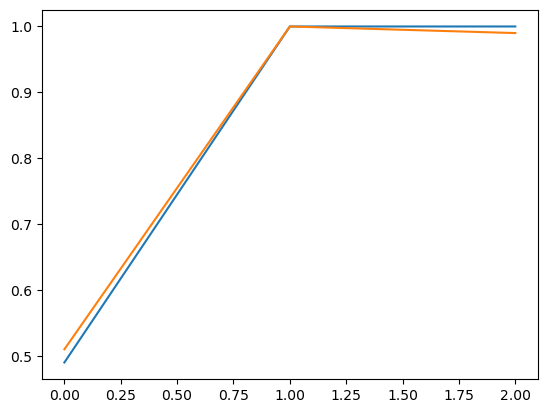

In [15]:
dfs = {result.path: result.metrics_dataframe for result in results}
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.val_accuracy.plot(ax=ax, legend=False)

## Storing results

In [34]:
output_path = benchmark_config['output_dir']

# make sure that output_dir exists
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [35]:
# save general configs
export_as(default_config, os.path.join(output_path, "general_config.yaml"), save_type='yaml')

In [36]:
# save results dataframe
results.get_dataframe().to_csv(os.path.join(output_path, "results.csv"), index=None)

In [37]:
# for each trial save results
for result in results:
    # get metrics
    trial_metrics = result.metrics_dataframe

    # get trial id
    trial_id = trial_metrics.trial_id[0]

    # get config
    trial_config = result.config

    # saving
    trial_metrics.to_csv(os.path.join(output_path, f"{trial_id}.csv"), index=None)
    export_as(trial_config, os.path.join(output_path, f"{trial_id}.yaml"), save_type='yaml')